# Dependencies

In [120]:
import numpy as np
from numpy import mean
from numpy import std

In [121]:
import pandas as pd

In [122]:
import sklearn as sk
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [123]:
import matplotlib.pyplot as plt

In [124]:
import seaborn as sns

# Make Synthetic Data

In [125]:
X, Y = make_classification(
    n_samples = 2000, 
    n_features = 2, # number of x columns
    n_redundant = 0, 
    n_clusters_per_class = 2, 
    flip_y = 0.6, # add noise
    weights = [0.8], # set dataset imbalance
    class_sep = 1.1, # set class separation
    random_state = 1 
)

In [126]:
df = pd.concat([pd.DataFrame(X), pd.Series(Y)], axis=1) #concatenate to dataframe

In [127]:
df.columns = ['x1','x2','y'] # rename columns
#print(df) # unhashtag to check dataset

## Plot Dataset

In [128]:
def plot(df: pd.DataFrame, x1: str, x2: str, y: str, title: str = '', save: bool = False, figname='figure.png'):
    plt.figure(figsize=(14, 7))
    plt.scatter(x=df[df[y] == 0][x1], y=df[df[y] == 0][x2], label='y = 0')
    plt.scatter(x=df[df[y] == 1][x1], y=df[df[y] == 1][x2], label='y = 1')
    plt.title(title, fontsize=20)
    plt.legend()
    if save:
        plt.savefig(figname, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()

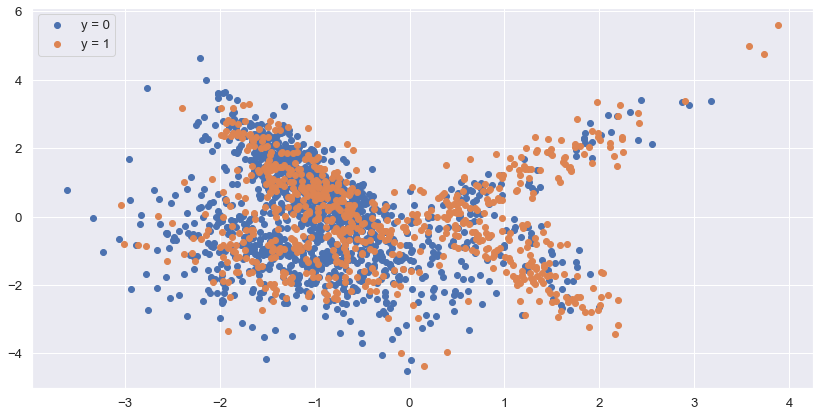

In [129]:
plot(df=df, x1='x1', x2='x2', y='y')


# Supervised Models

## Group Models

In [130]:
X = df.drop(['y'],axis=1)
Y = df.y
clf1 = RandomForestClassifier(max_depth=2, random_state=1) # RF
clf2 = GradientBoostingClassifier(max_depth=2, random_state=1) # XGBoost
ypred1 = cross_val_predict(clf1, X, Y, cv=10)
ypred2 = cross_val_predict(clf2, X, Y, cv=10)
#print(classification_report(Y, ypred1)) # unhashtag to print RF classification report for dataframe
#print(classification_report(Y, ypred2)) # unhashtag to print XGBoost classification report for dataframe



## Bespoke Models

In [131]:
#split dataframe into 25 equal chunks
def split_dataframe_by_position(df, splits): 
    dataframes = []
    index_to_split = len(df) // splits
    start = 0
    end = index_to_split
    for split in range(splits):
        temp_df = df.iloc[start:end, :]
        dataframes.append(temp_df)
        start += index_to_split
        end += index_to_split
    return dataframes
split_dataframes = split_dataframe_by_position(df, 25)
#print(split_dataframes) # unhashtag to check split dataframes

In [132]:
for df in split_dataframes:
    #df = list_df[]
    X = df.drop(['y'],axis=1)
    Y = df.y
    clf1 = RandomForestClassifier(max_depth=2, random_state=1) # RF
    clf2 = GradientBoostingClassifier(max_depth=2, random_state=1) # XGBoost
    ypred1 = cross_val_predict(clf1, X, Y, cv=10)
    ypred2 = cross_val_predict(clf2, X, Y, cv=10)
    #print(classification_report(Y, ypred1)) # unhashtag to print RF classification report for each split dataframe
    #print(classification_report(Y, ypred2)) # unhashtag to print XGBoost classification report for each split dataframe


# Unsupervised Clustering

In [133]:
# calculate and concatenate PFIs for RF model of each split dataframe 
coef1 = []
for df in split_dataframes:
    X = df.drop(['y'],axis=1)
    Y = df.y
    clf1 = RandomForestClassifier(max_depth=2, random_state=1)
    clf1.fit(X, Y)
    result1 = permutation_importance(clf1, X, Y, n_repeats=10, random_state=1, n_jobs=2)
    feature_importances1 = pd.Series(result1.importances_mean, index=X.columns)
    coef1.append(feature_importances1)
coef1 = pd.concat(coef1,axis=1)

In [134]:
# calculate and concatenate PFIs for XGBoost model of each split dataframe 
coef2 = []
for df in split_dataframes:
    X = df.drop(['y'],axis=1)
    Y = df.y
    clf2 = GradientBoostingClassifier(max_depth=2, random_state=1)
    clf2.fit(X, Y)
    result2 = permutation_importance(clf2, X, Y, n_repeats=10, random_state=1, n_jobs=2)
    feature_importances2 = pd.Series(result2.importances_mean, index=X.columns)
    coef2.append(feature_importances2)
coef2 = pd.concat(coef2,axis=1)

In [135]:
# concatenate PFIs for all RF and XGBoost models
coef = pd.concat([coef1, coef2])
print(coef)

         0        1        2        3        4        5        6        7   \
x1  0.12125  0.21125  0.19000  0.12750  0.07000  0.16125  0.20125  0.07375   
x2  0.02375  0.02250  0.00875  0.05250  0.05000  0.03875  0.00375  0.04875   
x1  0.20375  0.37875  0.34500  0.32000  0.27875  0.36000  0.34000  0.33500   
x2  0.20625  0.19875  0.14125  0.14875  0.15125  0.18625  0.17375  0.29250   

         8        9   ...       15      16       17       18       19  \
x1  0.15000  0.13625  ...  0.04375  0.1425  0.21750  0.17500  0.05750   
x2  0.05750  0.08125  ...  0.04750  0.0425  0.02625  0.08750  0.08375   
x1  0.42750  0.22875  ...  0.12000  0.3450  0.39500  0.32625  0.16000   
x2  0.15125  0.17000  ...  0.35125  0.1000  0.08500  0.23000  0.27500   

         20       21       22       23       24  
x1  0.07625  0.12875  0.19125  0.02500  0.07125  
x2  0.07000  0.00250  0.00750  0.04875  0.03250  
x1  0.26500  0.28875  0.36750  0.18750  0.24875  
x2  0.18750  0.12625  0.18875  0.29875  0.1

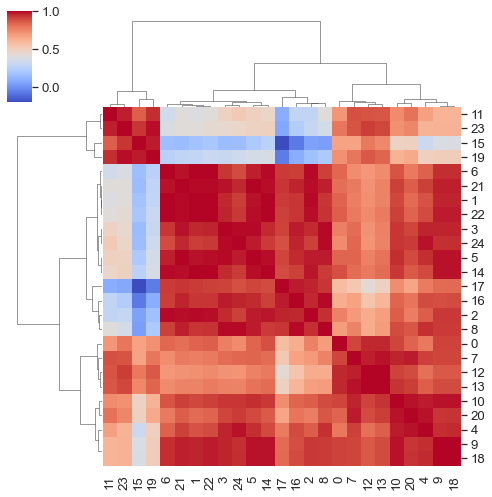

In [136]:
# plot clustermap using pairwise correlation as metric and ward as method
sns.clustermap(coef.corr(),yticklabels=True,xticklabels=True,method='ward', figsize=(7,7), cmap="coolwarm")
sns.set(font_scale=1.2)#dates removed 22h